In [1]:
import pickle #read pickle file
import coffea
from coffea import hist
import topcoffea.modules.HistEFT as HistEFT
import topcoffea.modules.eft_helper as efth
import gzip #read zipped pickle file
import matplotlib.pyplot as plt #plot histograms
from matplotlib.backends.backend_pdf import PdfPages
import topcoffea.modules.utils as utils
import mplhep as hep
import numpy as np

/afs/crc.nd.edu/user/h/hnelson2/miniconda3/envs/ttbarEFT-env/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
hep.style.use("CMS")
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'legend.fontsize':20}
plt.rcParams.update(params)

In [3]:
wc_pts = {"ctGIm": 0.0, "ctGRe":0.0, "cQj38": 0.0, "cQj18": 0.0,
            "cQu8": 0.0, "cQd8": 0.0, "ctj8": 0.0, "ctu8": 0.0,
            "ctd8": 0.0, "cQj31": 0.0, "cQj11": 0.0, "cQu1": 0.0,
            "cQd1": 0.0, "ctj1": 0.0, "ctu1": 0.0, "ctd1": 0.0}

In [4]:
f1 = "S1_sow.pkl.gz"
f2 = "S2_sow.pkl.gz"
f3 = "S3_sow.pkl.gz"
f4 = "S4_sow.pkl.gz"
f5 = "S5_sow.pkl.gz"

files = ["S1_sow.pkl.gz", "S2_sow.pkl.gz", "S3_sow.pkl.gz", "S4_sow.pkl.gz", "S5_sow.pkl.gz"]

In [5]:
def get_hist(fname, hist_name):
    hists = utils.get_hist_from_pkl(fname, allow_empty=False)
    h = hists[hist_name]
    return h

def calc_weight_array(hist, wc_range, wc_name):
    '''
    Calculate the sum of event weights for a range of values of a 
    single wc while all others are frozen at 0. 
    Parameters
    ----------
    hist : single HistEFT histogram
        needs to be a 1 bin histogram in order to get the correct output
    wc_range : list
        List of wc values to calculate histogram event weight at
        eg. np.arange(min, max, increment)
    wc_lst : list
        list of all WC contained in the histogram
    wc_name : str
        single wc that will be scanned

    Returns: 
        A nested list of values
        [[wc_range], [hist.values() at each point in wc_range]]
    '''

    wc_lst = hist._wcnames

    weight_pts = [] 
    weights = []
    wc_vals = {}
    
    # set all initial WC values to 0.0
    for item in wc_lst:
        wc_vals[item] = 0.0

    # loop through different values of the wc coeff, get sum of event weights
    for i in wc_range:
        wc_vals.update({wc_name:i})
        hist.set_wilson_coefficients(**wc_vals)
        weight = hist.values()
        weights.extend([list(w)[0] for w in weight.values()])

    weight_pts.append(wc_range)
    weight_pts.append(weights)
        
    return weight_pts

def make_1d_quad_plot(files, hist_name, wc_range, wc_name):
    '''
    Make 1d quadratic plot of wc value versus total event weight
    Parameters
    ----------
    files : list
        List of .pkl.gz files to run over
    hist_name : str
        Histogram name to use to get event weight values
    wc_range : list
        List of wc values to calculate histogram event weight at
    wc_name : str
        single wc that will be scanned
    '''
    
    plot_vals = {}

    for fname in files: 
        if fname.endswith('.pkl.gz'):
            label = fname[:-7]
        else: 
            label = fname
        hist = get_hist(fname, hist_name)
        weights = calc_weight_array(hist, wc_range, wc_name)
        plot_vals[label] = weights
    
    fig, ax = plt.subplots()
    for item in plot_vals:
        ax.plot(plot_vals[item][0], plot_vals[item][1], label = item)

    ax.legend()
    fig.suptitle(wc_name)
    plt.show()
    # figname = "quad_1d_"+wc_name+".png"
    # fig.savefig(figname)
    # print("plot saved to: ", figname)
    # plt.close(fig)

In [7]:
def get_total_sow(fname, hist_name, wc_vals):
    h = get_hist(fname, hist_name)
    h.set_wilson_coefficients(**wc_vals)
    weight = h.values()
    return weight

In [8]:
wc_ref_pts = {'ctGIm': 1, 'ctGRe':0.7, 'cQj38':9.0, 'cQj18':7.0,
            'cQu8':9.5, 'cQd8':12.0, 'ctj8':7.0, 'ctu8':9.0,
            'ctd8':12.4, 'cQj31':3.0, 'cQj11':4.2, 'cQu1':5.5,
            'cQd1':7.0, 'ctj1':4.4, 'ctu1':5.4, 'ctd1':7.0}

In [9]:
weight = get_total_sow(f1, "nevents", wc_ref_pts)

In [10]:
print(weight)

{('TT01j2l_S1',): array([31394.8638117])}


In [12]:
weight = get_total_sow(f1, "nevents", wc_pts)
print(weight)

{('TT01j2l_S1',): array([5056.37757625])}


In [20]:
def make_1d_quad_plot_with_manual(files, hist_name, wc_range, wc_name, manual_lst):
    '''
    Make 1d quadratic plot of wc value versus total event weight
    Parameters
    ----------
    files : list
        List of .pkl.gz files to run over
    hist_name : str
        Histogram name to use to get event weight values
    wc_range : list
        List of wc values to calculate histogram event weight at
    wc_name : str
        single wc that will be scanned
    '''
    
    plot_vals = {}

    for fname in files: 
        if fname.endswith('.pkl.gz'):
            label = fname[:-7]
        else: 
            label = fname
        hist = get_hist(fname, hist_name)
        weights = calc_weight_array(hist, wc_range, wc_name)
        plot_vals[label] = weights
    
    fig, ax = plt.subplots()
    for item in plot_vals:
        ax.plot(plot_vals[item][0], plot_vals[item][1], label = item)

    ax.scatter(manual_lst[0], manual_lst[1], label = "Dedicated")
    
    ax.legend()
    fig.suptitle(wc_name)
    plt.show()
    # figname = "quad_1d_"+wc_name+".png"
    # fig.savefig(figname)
    # print("plot saved to: ", figname)
    # plt.close(fig)

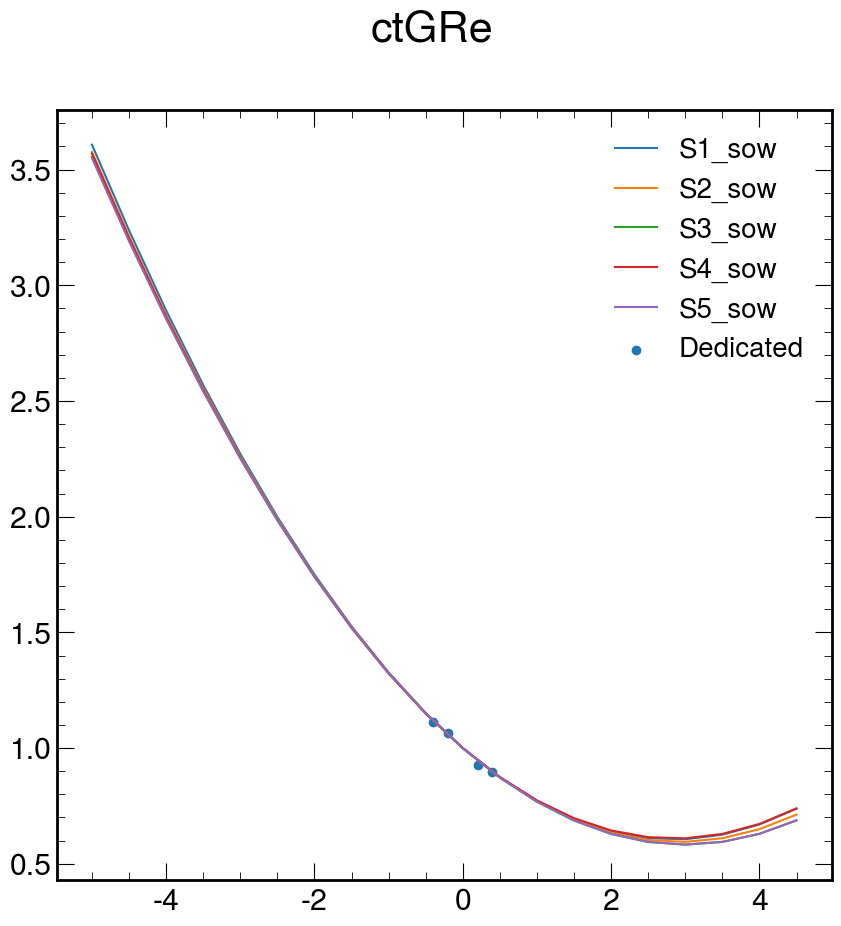

In [22]:
manual_lst = [[-0.4, -0.2, 0.2, 0.4],[54.95/49.41, 52.73/49.41, 45.89/49.41, 44.27/49.41]]

make_1d_quad_plot_with_manual(files, "sow", np.arange(-5.0, 5.0, 0.5), "ctGRe", manual_lst)